In [173]:
import os
import sys
import math
import numpy as np
import numpy.linalg
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import fcsparser

def CD34_celltype_assign(data, gates_in, data_name, save = True):
#Takes 3 inputs, source df, gates dictionary, string containing name for data output
#Assume sort gates actually dumped dead, lin pos cells

    data_in = data.copy()

    #Create boolean matrix based on gates in new columns

    data_in['CD34_pos'] = data_in['CD34-PE'] >= gates_in['CD34-PE']
    data_in['CD38_pos'] = data_in['CD38-APC-cy7'] >= gates_in['CD38-APC-cy7']
    data_in['CD38_neg'] = data_in['CD38-APC-cy7'] < gates_in['CD38-APC-cy7']
    data_in['IL1RAP_pos'] = data_in['IL1RAP-APC'] >= gates_in['IL1RAP-APC']
    data_in['IL1RAP_neg'] = data_in['IL1RAP-APC'] < gates_in['IL1RAP-APC']
    data_in['CD45RA_pos'] = data_in['CD45RA-FITC'] >= gates_in['CD45RA-FITC']
    data_in['CD45RA_neg'] = data_in['CD45RA-FITC'] < gates_in['CD45RA-FITC']
    data_in['CD123_pos'] = data_in['CD123-PE-Cy7'] >= gates_in['CD123-PE-Cy7']
    data_in['CD123_neg'] = data_in['CD123-PE-Cy7'] < gates_in['CD123-PE-Cy7']
    data_in['CD90_pos'] = data_in['CD90-BV421'] >= gates_in['CD90-BV421']
    data_in['CD90_neg'] = data_in['CD90-BV421'] < gates_in['CD90-BV421']


    #Define each cell type - doing this explicitly to make code easier to follow. Tweaked to include IL1RAP neg for normal 38- cells

    mds_sc1 = ['CD34_pos','CD38_neg','IL1RAP_pos']
    mds_sc2 = ['CD34_pos','CD38_neg','CD45RA_pos']
    mds_sc3 = ['CD34_pos','CD38_neg','CD123_pos']
    hsc = ['CD34_pos','CD38_neg','IL1RAP_neg','CD45RA_neg','CD123_neg','CD90_pos']
    mpp = ['CD34_pos','CD38_neg','IL1RAP_neg','CD45RA_neg','CD123_neg','CD90_neg']
    cmp = ['CD34_pos','CD38_pos','CD45RA_neg','CD123_pos']
    gmp = ['CD34_pos','CD38_pos','CD45RA_pos','CD123_pos']
    gmp2 = ['CD34_pos','CD38_pos','CD45RA_pos','CD123_neg'] 
    mep = ['CD34_pos','CD38_pos','CD45RA_neg','CD123_neg']


    markers = [
        'CD34_pos' ,
        'CD38_pos' ,
        'CD38_neg' ,
        'IL1RAP_pos' ,
        'CD45RA_pos' ,
        'CD45RA_neg' ,
        'CD123_pos' ,
        'CD123_neg' ,
        'CD90_pos' ,
        'CD90_neg'
    ]

    col_names = ['mds_sc1', 'mds_sc2','mds_sc2','hsc', 'mpp', 'cmp', 'gmp', 'gmp2','mep']
    celltypes = ['MDS_SC', 'MDS_SC','MDS_SC','HSC', 'MPP',  'CMP', 'GMP', 'GMP2', 'MEP']
    alltypes = [mds_sc1, mds_sc2, mds_sc3, hsc, mpp, cmp, gmp, gmp2, mep]

    #Store list of which columns are true for each cell type in a dictionary

    criteria = dict(zip(col_names, alltypes))


    #Use calculated criteria to add cell type true/false columns

    for x in col_names:
        data_in[x] = (data_in[criteria[x]] == True).all(axis = 1)

    data_in['unassigned'] = (data_in[col_names] == False).all(axis = 1)

    #Create a new column that contains the cell type

    col_names.append('unassigned')  #account for cells that were not assigned
    celltypes.append('unassigned')

    for a, b in zip(col_names, celltypes):

        data_in.loc[data_in[a] == True, 'celltype'] = b 

    #Define colour palette here, and make a new column for it

    ct = data_in['celltype'].drop_duplicates().to_list()
    col = sns.color_palette('husl', n_colors = len(ct))
    palette = dict(zip(ct, col))
    data_in['Colour'] = data_in['celltype'].map(palette)

    #Create a file containing assigned cell type for each well
    if save == True:
        data_in.to_csv(f'../Data/{data_name}_index.tsv', sep = '\t')    #Save the big df to a file
        #wellID = data_in[['Plate_Well', 'celltype']] #don't need this and it make sthe fucntion fail for bulk cell

    #Make a plot of cell type distributions

    fig, ax = plt.subplots()

    c = data_in['celltype'].value_counts().rename_axis('cell').reset_index(name='counts')
    ax = sns.barplot(x='cell', y='counts', data = c, palette = palette)

    fig.suptitle(f'{data_name}', fontsize=16)
    fig.savefig(f'../Results/Indexing/{data_name}_celltype_dist.png',dpi=300) 
    
    return data_in


def CD34_plot_bulk(sample,backgrounddf, gates):
    #Annatina: modified your plotting function to plot a big background sample and a smaller foreground subset
    
    plot_list = [
        ['FSC-A', 'SSC-A'],
        ['FSC-A', 'FSC-W'],
        ['SSC-A', 'SSC-H'],
        ['Zombie', 'Lin-PE-Cy5'], 
        ['CD34-PE', 'CD38-APC-cy7'],
        ['IL1RAP-APC', 'CD38-APC-cy7'],
        ['CD45RA-FITC', 'CD123-PE-Cy7'],
        ['CD45RA-FITC', 'CD90-BV421']
    ]
    
    #Which fluorophores are on a log scale
    logs = ['Lin-PE-Cy5', 'CD34-PE','CD38-APC-cy7', 'CD45RA-FITC','CD123-PE-Cy7','Zombie', 'IL1RAP-APC', 'CD90-BV421' ]

    fig, axs = plt.subplots(4,2, figsize = (13,24))
    axs = axs.ravel()
    fig.subplots_adjust(hspace = 0.3, wspace=.3)

    for ax,y in zip(axs, plot_list):
        x_label = y[0]
        y_label = y[1]
        ax.scatter(backgrounddf[x_label] + 11, backgrounddf[y_label] + 11, alpha = 0.005, c = 'silver', s = 5)
        ax.scatter(sample[x_label] + 11, sample[y_label] + 11, alpha = 0.2, c = sample['Colour'],  s = 5)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
       #ax.legend()
        if x_label in logs:
            ax.set_xscale('log')
            ax.set_xlim(left = 10)
        if y_label in logs:
            ax.set_yscale('log')
            ax.set_ylim(bottom = 10)
        if x_label in gates:
            ax.axvline(gates[x_label], ls = '--', c = 'k')
        if y_label in gates:
            ax.axhline(gates[y_label], ls = '--', c = 'k')   
        
        ax.autoscale_view()  

In [169]:
#Next step is to set gates for each fluorophore. These are adjusted in this cell for now
#Raw data
CD34_gate_loc = {
    'Lin-PE-Cy5': 2000,
    'CD34-PE': 280 ,
    'CD38-APC-cy7': 3000 ,
    'CD45RA-FITC': 1000 ,
    'CD123-PE-Cy7': 400,
    'Zombie': 8000,
    'IL1RAP-APC': 800,
    'CD90-BV421': 500,
}

#Compensated data
CD34_gate_loc_comp = {
    'Lin-PE-Cy5': 1000,
    'CD34-PE': 280 ,
    'CD38-APC-cy7': 2500 ,
    'CD45RA-FITC': 1000 ,
    'CD123-PE-Cy7': 200,
    'Zombie': 8000,
    'IL1RAP-APC': 300,
    'CD90-BV421': 500,
}

#Raw PB data
PB_gate_loc = {
    'CD16-PE': 500,
    'CD14-Pe-Cy5': 5000 ,
    'CD56-PE-Cy7': 1000 ,
    'CD66b-BV421': 2500 ,
    'Zombie': 2500,
    'CD45-FITC': 1000,
    'Cd27-APC': 3000,
    'IgD-BB700': 3500,
    'R780/60-A':1000
}

#Comp PB data
PB_gate_loc_comp = {
    'CD16-PE': 500,
    'CD14-Pe-Cy5': 1000 ,
    'CD56-PE-Cy7': 400 ,
    'CD66b-BV421': 2000 ,
    'Zombie': 1500,
    'CD45-FITC': 1000,
    'Cd27-APC': 1000,
    'IgD-BB700': 3500,
    'R780/60-A':1000
}

In [170]:
# Get bulk-fcs files from AS

bulkdirectory = '../Data/RN_BM/Bulk/'

bulkdict = {}
bulkcompdict = {}
    
for filename in os.listdir(bulkdirectory):
    fn = os.path.join(bulkdirectory, filename)
    plateid = (fn.split('/'))[4]
    #count += 1

    meta, data = fcsparser.parse(fn, reformat_meta=True)
    
    # Get antibodies and rename with well names: The fmo and single stains don't have the info in their metadata
    # therefore just pasting the correct dictionnary here
    
    channeld = {'YG582/15-A': 'CD34-PE',
     'YG670/30-A': 'Lin-PE-Cy5',
     'YG780/60-A': 'CD123-PE-Cy7',
     'V450/50-A': 'CD90-BV421',
     'V610/20-A': 'Zombie',
     'B530/30-A': 'CD45RA-FITC',
     'R660/20-A': 'IL1RAP-APC',
     'R780/60-A': 'CD38-APC-cy7'}
    
    # Load compensation
    comp_fields = meta['SPILL'].split(',')
    n = int(comp_fields[0])
    channels = comp_fields[1: n+1]
    matrix = np.asarray(comp_fields[n+1:]).astype(np.float64).reshape((n, n)) 
 
    matrix = numpy.linalg.inv(matrix)
    
    spill_matrix = pd.DataFrame(
        matrix,
        index=channels,
        columns=channels,
    )  #spill_matrix is the comp matrix
    
    #Plots compensation matrix
    # Reorder the dyes by wavelength
    wls = [int(x.split('/')[0][-3:]) for x in channels]
    idx = np.argsort(wls)
    spill_by_wls = spill_matrix.iloc[idx].T.iloc[idx].T

    
    #Apply comp and replace column names with antibodies
    data_comp = data.copy()
    compensation = spill_matrix
    
    for channel in channels:
        data_comp[channel] = compensation.loc[:,channel].values @ data[channels].values.T #@ for matrix multiplication
    
    #Store df and compdf for this iteration as a unique variable
    data_comp.rename(columns = channeld, inplace = True)
    data.rename(columns = channeld, inplace = True)
    
    #plate = plate_key.get(filename) #pull the plate name for this file and use to label output dictionaries
    plate = filename.strip(".fcs")
    data['Plate'] = plate #add new column with plate name
    data_comp['Plate'] = plate  #add new column with plate name
    bulkcompdict[plate] = data_comp #output df into a dictionary
    bulkdict[plate] = data  #output df into a dictionary
    
CD34_bulk = pd.concat(bulkdict.values(), axis = 0) #calculating uncomp, but don't use this again
CD34_bulkcomp = pd.concat(bulkcompdict.values(), axis = 0)

#Gate out a bunch of crap

sample = CD34_bulkcomp.copy()

bulkgate_loc_comp = {
    'FSC-A_lower' : 80000,
    'FSC-A_higher' : 225000,
    'SSC-A_lower' : 10000,
    'SSC-A_higher' : 130000,
    'Zombie' : 2500,
    'Lin-PE-Cy5' : 1000,
    'CD34-PE' : 280
}

sample = bulkcomp_ct.copy()
sample = sample.loc[sample['SSC-A'] > bulkgate_loc_comp['SSC-A_lower']].copy()
sample = sample.loc[sample['SSC-A'] < bulkgate_loc_comp['SSC-A_higher']].copy()
sample = sample.loc[sample['FSC-A'] > bulkgate_loc_comp['FSC-A_lower']].copy()
sample = sample.loc[sample['FSC-A'] < bulkgate_loc_comp['FSC-A_higher']].copy()
sample = sample.loc[sample['Zombie'] < bulkgate_loc_comp['Zombie']].copy()
sample = sample.loc[sample['Lin-PE-Cy5'] < bulkgate_loc_comp['Lin-PE-Cy5']].copy()
sample = sample.loc[sample['CD34-PE'] > bulkgate_loc_comp['CD34-PE']].copy()

CD34_bulkcomp_pregate = sample.copy()

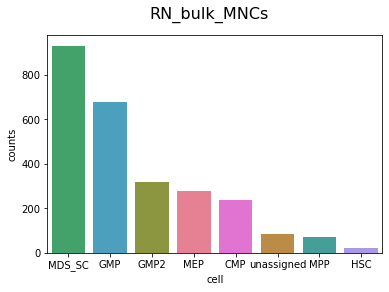

In [171]:
#Assign cell types to bulk data
CD34_bulkcomp_pregate_ct = CD34_celltype_assign(CD34_bulkcomp_pregate, CD34_gate_loc_comp, 'RN_bulk_MNCs', save = False)

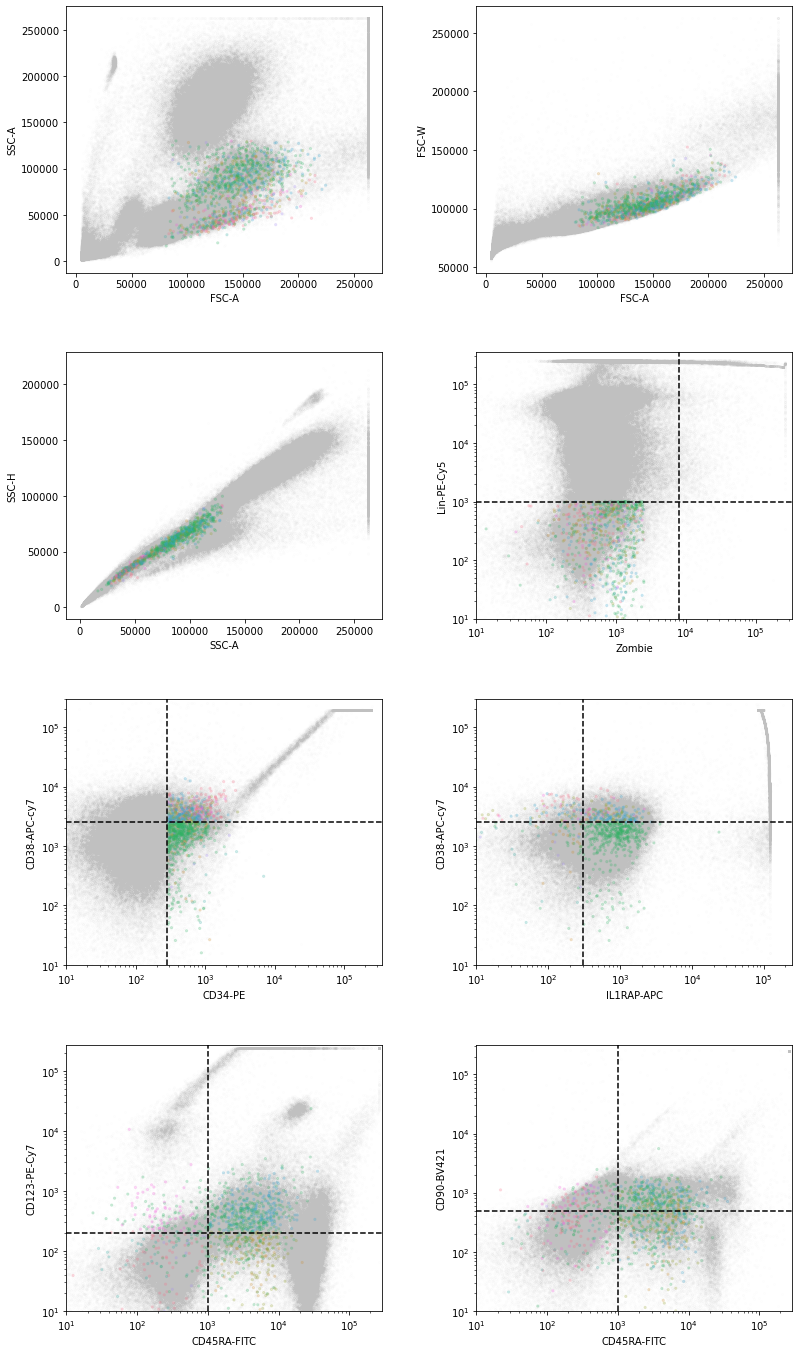

In [174]:
foreground = CD34_bulkcomp_pregate_ct.loc[CD34_bulkcomp_pregate['Plate'].isin(['FMO_123-PECY7_020', 'FMO_CD34-PE_016', 'FMO_CD38-APC-CY7_018', 'FMO_CD45RA-FITC_019', 'FMO_CD90-BV421_021', 'FMO_ILRAP-APC_022', 'FMO_LiPECy5_017','Sample_Unstained_010'])].copy()
background = CD34_bulkcomp.loc[CD34_bulkcomp['Plate'].isin(['Sample_MNC_011'])].copy()

CD34_plot_bulk(foreground,background, CD34_gate_loc_comp)